In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# 한글화
import koreanize_matplotlib 

In [2]:
# 파일 불러오기

review_df = pd.read_csv('./review_all_stop2_haspell.csv', encoding='utf-8', index_col=0) # df_review는 전체년도 리뷰 크롤링 파일
review_df.head()

,date,review,rating
0,2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,5
1,2023-09-09,필터 기능 잘 되어있어 편하게 쇼핑함,5
2,2023-09-09,배송이 빨라요 그리고 할인이 많아요,5
3,2023-09-09,50퍼 쿠폰 만원 빵빵하게 주는 곳 처음 봄 주문하면 6시간 만에 옴 이 앱 뭐지,5
4,2023-09-09,빠른 배송 좋아요,5


In [3]:
len(review_df)

14223

In [4]:
review_df['label'] = [1 if rate >=4 else 0 for rate in review_df['rating']]
review_df.head()

,date,review,rating,label
0,2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,5,1
1,2023-09-09,필터 기능 잘 되어있어 편하게 쇼핑함,5,1
2,2023-09-09,배송이 빨라요 그리고 할인이 많아요,5,1
3,2023-09-09,50퍼 쿠폰 만원 빵빵하게 주는 곳 처음 봄 주문하면 6시간 만에 옴 이 앱 뭐지,5,1
4,2023-09-09,빠른 배송 좋아요,5,1


In [5]:
review_df['label'].value_counts()

1    11938
0     2285
Name: label, dtype: int64

In [6]:
# 토큰화 - 명사
tokenize = Okt()

review_df['review_tokens'] = [ tokenize.nouns(re) for re in review_df['review'] ]

review_df[['review', 'review_tokens']].sample(10)

,review,review_tokens
3858,새벽 배송 너무 편해요 전날 시키면 다음날 배송 너무 좋아요,"[새벽, 배송, 전날, 다음, 날, 배송]"
10620,잘 사용하고 있어요 종류가 좀 더 다양했으면 좋겠어요,"[사용, 종류, 좀, 더]"
14536,저만 결제 안되나요 오랜만에 구매하려니 구매 창의 아예 안 떠요,"[결제, 만, 구매, 구매, 창의, 아예, 안]"
1218,잘 사용하고 있는데 계정 탈퇴는 어떻게 하나요 하고 싶은데 좀 알려주셔요,"[사용, 계정, 탈퇴, 하나요, 좀]"
9180,빠른 샛별 배송에 감탄밖에 안 나오네요 택배기사님들 감사합니다,"[샛별, 배송, 감탄, 안, 택배, 기사]"
8893,몇 주 전부터 앱 시작만 하면 계속 튕겨서 업데이트 안 해서 그런가 하고 구글 스토...,"[몇, 주, 전, 앱, 시작, 계속, 튕겨, 업데이트, 안, 런가, 구글, 스토어,..."
12367,정성이 담긴 것 같은 음식이라 만족스럽습니다,"[정성, 것, 음식]"
13536,매일 잘 사용 중,"[매일, 사용, 중]"
14476,별로,[별로]
4380,급할 때 새벽 배송이라 편해요,"[때, 새벽, 배송]"


In [7]:
# 결측치 제거

review_df['review_tokens'] = [None if len(tokens)==0 else tokens for tokens in review_df['review_tokens']]
review_df.dropna(axis=0,inplace=True)
review_df.reset_index(drop=True,inplace=True)
review_df.head(10)

,date,review,rating,label,review_tokens
0,2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,5,1,"[상세, 설명, 검색, 결과, 중량, 가격, 바로, 확인, 더]"
1,2023-09-09,필터 기능 잘 되어있어 편하게 쇼핑함,5,1,"[필터, 기능, 쇼핑, 함]"
2,2023-09-09,배송이 빨라요 그리고 할인이 많아요,5,1,"[배송, 할인]"
3,2023-09-09,50퍼 쿠폰 만원 빵빵하게 주는 곳 처음 봄 주문하면 6시간 만에 옴 이 앱 뭐지,5,1,"[쿠폰, 만원, 빵빵, 곳, 처음, 봄, 주문, 옴, 이, 앱, 뭐]"
4,2023-09-09,빠른 배송 좋아요,5,1,[배송]
5,2023-09-09,컬리 너무 좋다 리 뷰티 쿠폰 줘가지 규 사고팠던 퍼퓸이랑 플루랑 켄트 칫솔도 사궁...,5,1,"[컬리, 리, 뷰티, 쿠폰, 규, 사고, 퍼퓸, 플루, 켄트, 칫솔, 궁, 향, 기..."
6,2023-09-08,마켓 컬리 대박이에요,5,1,"[마켓, 컬리, 대박]"
7,2023-09-08,짱짱맨,5,1,[짱짱맨]
8,2023-09-08,배송이 완전 빠르고 제품 포장이 잘 되어와서 만족하고 있습니다,5,1,"[배송, 완전, 제품, 포장]"
9,2023-09-08,아니 컬리 팜 초대해도 안 열리던데,1,0,"[컬리, 초대, 안]"


In [8]:
# 벡터화에 필요한 작업 (띄어쓰기 붙여주기)

contents_for_vectorize = []

for content in review_df['review_tokens']: 
    sentence = ""
    for word in content:
        sentence = sentence + ' ' + word
        
    contents_for_vectorize.append(sentence)

In [9]:
review_df['review_tokens_vec'] = contents_for_vectorize
review_df.sample(5)

,date,review,rating,label,review_tokens,review_tokens_vec
5848,2021-04-19,초심을 잃지 않는 기업,5,1,"[초심, 기업]",초심 기업
102,2023-08-08,사용하기 편해요,5,1,[사용],사용
10875,2019-05-04,가격이 저렴하진 않지만 바빠서 마트에 가지 못하는 상황에 장을 볼 수 있어 너무 좋...,4,1,"[가격, 마트, 가지, 상황, 장, 볼, 수, 조금, 추가, 부분, 관심, 상품, ...",가격 마트 가지 상황 장 볼 수 조금 추가 부분 관심 상품 등록 수 당장 구매 건...
3849,2021-11-07,최고예요,5,1,[최고],최고
1943,2022-06-20,20121 사용하기가 편하고 우선 새벽 배송이 최고네요,5,1,"[사용, 우선, 새벽, 배송, 최고]",사용 우선 새벽 배송 최고


In [10]:
review_df.to_csv('[JHS]review_preprocessed_vector(nouns).csv', index=False)

In [11]:
# 파일 불러오기

review_df = pd.read_csv('./[JHS]review_preprocessed_vector(nouns).csv', encoding='utf-8', index_col=0) # df_review는 전체년도 리뷰 크롤링 파일
review_df.head()

,review,rating,label,review_tokens,review_tokens_vec
date,,,,,
2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,5,1,"['상세', '설명', '검색', '결과', '중량', '가격', '바로', '확인...",상세 설명 검색 결과 중량 가격 바로 확인 더
2023-09-09,필터 기능 잘 되어있어 편하게 쇼핑함,5,1,"['필터', '기능', '쇼핑', '함']",필터 기능 쇼핑 함
2023-09-09,배송이 빨라요 그리고 할인이 많아요,5,1,"['배송', '할인']",배송 할인
2023-09-09,50퍼 쿠폰 만원 빵빵하게 주는 곳 처음 봄 주문하면 6시간 만에 옴 이 앱 뭐지,5,1,"['쿠폰', '만원', '빵빵', '곳', '처음', '봄', '주문', '옴', ...",쿠폰 만원 빵빵 곳 처음 봄 주문 옴 이 앱 뭐
2023-09-09,빠른 배송 좋아요,5,1,['배송'],배송


In [12]:
# 벡터화
vectorizer_tfidf = TfidfVectorizer(min_df=5, decode_error='ignore') # max_features=3000

contents_for_vectorize = review_df['review_tokens_vec']
X = vectorizer_tfidf.fit_transform(contents_for_vectorize)
X.shape

(11412, 1164)

In [13]:
y = review_df['label']
y.shape

(11412,)

In [14]:
#  로지스틱 회귀 학습하기

X = vectorizer_tfidf.fit_transform(contents_for_vectorize)
y = review_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=review_df['label'])

lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train, y_train)

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
print('Test Acc : ', accuracy_score(y_test, y_pred_test))

Train Acc :  0.9162011173184358
Test Acc :  0.8931230836618484


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
finish


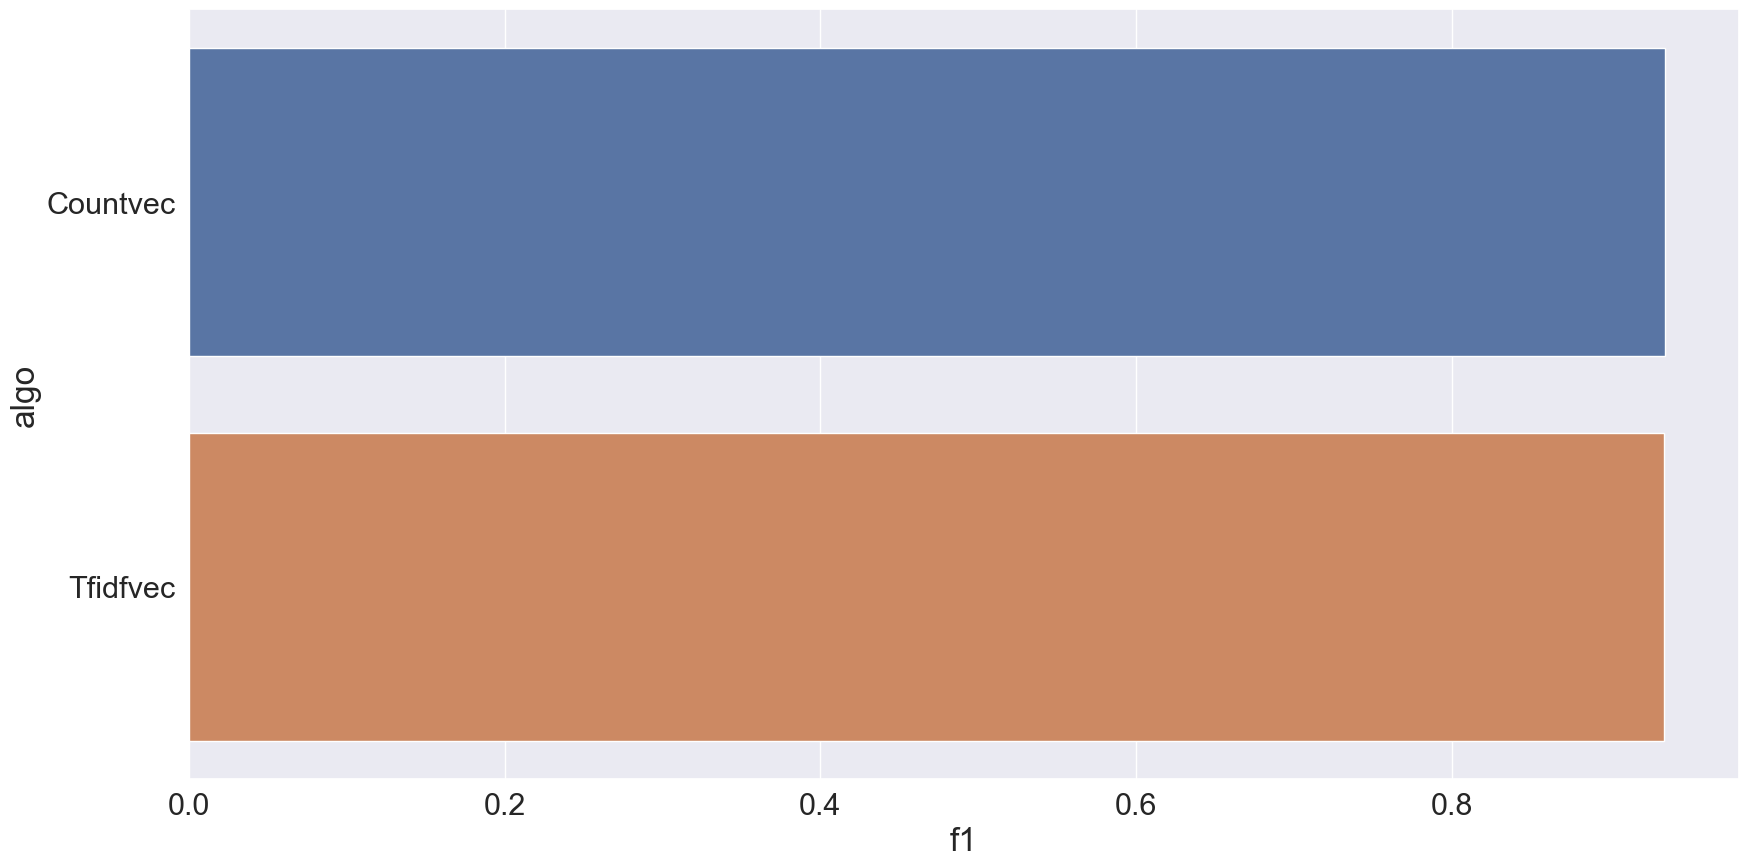

In [16]:
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score , recall_score, f1_score

X = review_df['review_tokens_vec']
y = review_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

skfold = StratifiedKFold(n_splits=5)

pipe_countvec = Pipeline([
                ('vec', CountVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression())])

pipe_tfidfvec = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression())])

# vec -> ngram_range = (1, 2))
k = [1,5,10,20] # 벡터화 문장이 몇번 반복되는지 최소 반복수
max_iters = [500, 1000, 1500, 2000] # gradientdecent 얼마나 반복할건지 반복수
cs = [0.01, 0.1, 1, 5] # 규제 정도, 클수록 훈련을 복잡하게한다.(규제가 약하다는 소리) -> 하지만 과적합 우려
penaltys = ['l1','l2'] # 규제를 뭐로 할거냐

grid_params_countvec = [{
    "vec__min_df" : k,
    "fit__C": cs,
    "fit__solver" : ["liblinear","saga"],
    "fit__penalty" : penaltys,
    "fit__max_iter": max_iters
}]

grid_params_tfidfvec = [{
    "vec__min_df" : k,
    "fit__C": cs,
    "fit__solver" : ["liblinear","saga"],
    "fit__penalty" : penaltys,
    "fit__max_iter": max_iters
}]


pipe = [pipe_countvec , pipe_tfidfvec ]
params = [grid_params_countvec , grid_params_tfidfvec]

jobs = 20

grid_dict = {
    0: 'Countvec', 
    1: 'Tfidfvec',
            }

model_object = {}; model_acc = {}; model_preci = {}; model_recall = {}; model_f1 = {}; model_best_params = {}

#1. scoring = 'neg_mean_absolute_error' 로 설정.
# 일반적으로 scoring을 값이 클 수록 모델 성능이 좋은 것으로 사이킷런에서 인식하는데, 
# mae는 값이 클 수록 모델 성능이 저하되는 것이므로 Negative 키워드를 붙여서 사용

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold,
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    model_object[grid_dict.get(idx)] = search
    model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    model_preci[grid_dict.get(idx)] = precision_score(y_test, y_pred)
    model_recall[grid_dict.get(idx)] = recall_score(y_test, y_pred)
    model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [17]:
model_f1

{'Countvec': 0.9352248394004282, 'Tfidfvec': 0.9345895020188426}

In [18]:
model_recall

{'Countvec': 0.9662610619469026, 'Tfidfvec': 0.9601769911504425}

In [19]:
model_acc

{'Countvec': 0.8939991239597022, 'Tfidfvec': 0.8935611038107752}

In [20]:
model_preci

{'Countvec': 0.9061203319502075, 'Tfidfvec': 0.9103303618248558}

In [21]:
model_best_params

{'Countvec': {'fit__C': 5,
  'fit__max_iter': 500,
  'fit__penalty': 'l2',
  'fit__solver': 'liblinear',
  'vec__min_df': 1},
 'Tfidfvec': {'fit__C': 5,
  'fit__max_iter': 500,
  'fit__penalty': 'l2',
  'fit__solver': 'liblinear',
  'vec__min_df': 1}}

In [22]:
best_model = model_object["Countvec"].best_estimator_.named_steps.fit
best_model

LogisticRegression(C=5, max_iter=500, solver='liblinear')

In [23]:
best_model.coef_

array([[ 0.35094255,  0.08510401, -0.8473742 , ..., -1.52499718,
        -0.00353281,  0.42154301]])

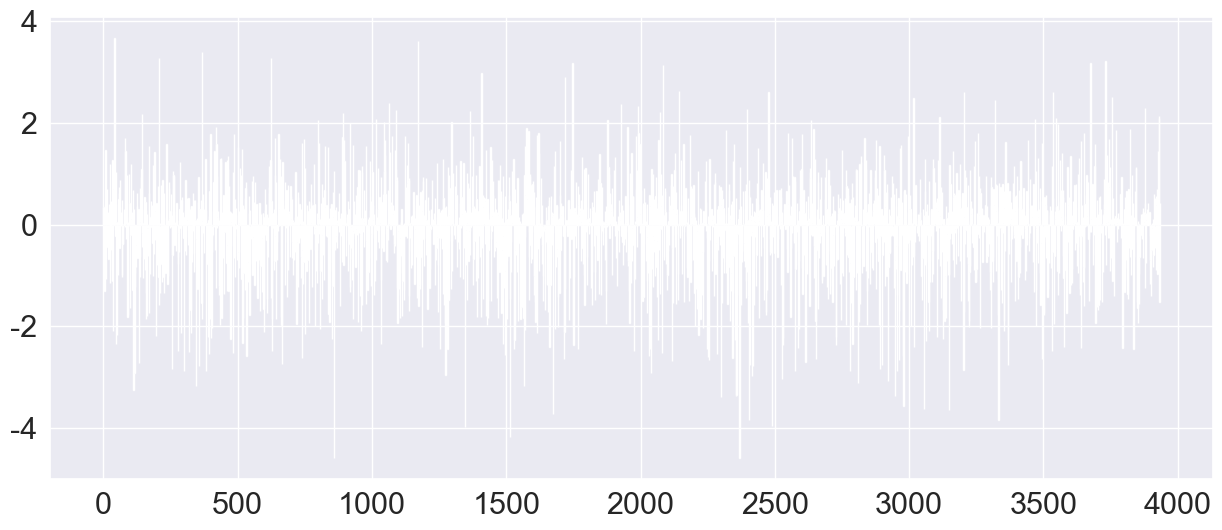

In [24]:
plt.figure(figsize=(15, 6))
plt.bar(range(len(best_model.coef_[0])), best_model.coef_[0]);

## 긍정 부정 키워드 결과 추출

In [26]:
# 벡터화
vectorizer_count = CountVectorizer(min_df=1, decode_error='ignore') # max_features=3000

contents_for_vectorize = review_df['review_tokens_vec']
X = vectorizer_count.fit_transform(contents_for_vectorize)
X.shape

(11412, 4410)

In [27]:
vectorizer_count.vocabulary_

{'상세': 1830,
 '설명': 1943,
 '검색': 196,
 '결과': 216,
 '중량': 3448,
 '가격': 3,
 '바로': 1373,
 '확인': 4340,
 '필터': 4138,
 '기능': 475,
 '쇼핑': 2048,
 '배송': 1453,
 '할인': 4197,
 '쿠폰': 3869,
 '만원': 1144,
 '빵빵': 1726,
 '처음': 3650,
 '주문': 3407,
 '컬리': 3823,
 '뷰티': 1674,
 '사고': 1738,
 '퍼퓸': 4023,
 '플루': 4120,
 '켄트': 3835,
 '칫솔': 3785,
 '기대': 477,
 '다리': 714,
 '마켓': 1126,
 '대박': 806,
 '짱짱맨': 3580,
 '완전': 2682,
 '제품': 3329,
 '포장': 4066,
 '초대': 3691,
 '샴푸': 1900,
 '구매': 377,
 '남편': 605,
 '물건': 1319,
 '자주': 3093,
 '하라': 4149,
 '상품': 1847,
 '식품': 2204,
 '주니': 3396,
 '정말': 3277,
 '마음': 1112,
 '드네': 958,
 '만족': 1147,
 '새벽': 1859,
 '아주': 2324,
 '사용': 1767,
 '가입': 40,
 '적립금': 3187,
 '애용': 2387,
 '이벤트': 2912,
 '고요': 283,
 '다른': 713,
 '저기': 3171,
 '담당': 768,
 '부서': 1618,
 '개선': 134,
 '요청': 2727,
 '제대로': 3307,
 '운영': 2763,
 '오오오오': 2638,
 '결제': 221,
 '오늘': 2613,
 '최고': 3710,
 '베송': 1518,
 '진작': 3545,
 '이용': 2927,
 '진짜': 3550,
 '수가': 2051,
 '시간': 2151,
 '계산': 247,
 '냉동식품': 631,
 '이전': 2937,
 '예상': 2599,
 '알람': 2371,

In [30]:
id_to_word = {v: k for k, v in vectorizer_count.vocabulary_.items()}
print(id_to_word[10])
print(len(id_to_word))

가까이
4410


In [31]:
coef_index = sorted(((value, index) for index, value in enumerate(best_model.coef_[0])), reverse = False)
coef_neg_index = coef_index[:10]
coef_pos_index = coef_index[-10:]
print(coef_pos_index[-3:])
print(coef_neg_index [:3])

[(3.3845647382242587, 367), (3.6010092542017333, 1171), (3.6692782646726907, 41)]
[(-4.582545351487052, 858), (-4.5786352335450005, 2368), (-4.169944208959877, 1514)]


In [32]:
print('긍정리뷰 키워드: ', id_to_word[367],id_to_word[1171], id_to_word[41]) 
print('부정리뷰 키워드: ', id_to_word[858],id_to_word[2368], id_to_word[1514])

긍정리뷰 키워드:  구경만 맞춤 가입자
부정리뷰 키워드:  더하기 알뜰 벙어리


## 시각화

In [33]:
pos_top_word=[] 
pos_top_score=[]
for coef in coef_pos_index:
    print(id_to_word[coef[1]], coef[0])
    pos_top_word.append(id_to_word[coef[1]])
    pos_top_score.append(coef[0])

neg_top_word=[] 
neg_top_score=[]
for coef in coef_neg_index:
    print(id_to_word[coef[1]], coef[0])
    neg_top_word.append(id_to_word[coef[1]])
    neg_top_score.append(coef[0])

반했어 2.9805759497581343
수제 3.1252280179596488
체감 3.1652222946313504
사라 3.1799811612323627
추가 3.2180049708116565
게임 3.265278593965011
내비게이션 3.265278593965011
구경만 3.3845647382242587
맞춤 3.6010092542017333
가입자 3.6692782646726907
더하기 -4.582545351487052
알뜰 -4.5786352335450005
벙어리 -4.169944208959877
미자 -3.969193937420161
엄마 -3.9640526149977027
야호 -3.840616122557744
젠장 -3.8386931290829693
브라우저 -3.7291332477145924
재고 -3.6507098034150296
입회 -3.632599469722243


In [34]:
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    print("Hangul set complete in your MAC!")
    rc("font", family = "Arial Unicode MS")
    
elif platform.system() == "Windows":
    print("Hangul set complete in your Windows!")
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family = font_name)

else:
    print("Unknown your system....")
    
plt.rcParams["axes.unicode_minus"] = False

def seaborn_Hangul():
    ## seaborn 한글
    plt.rc("font", family = "Malgun Gothic")
    sns.set(font="Malgun Gothic", 
    rc={"axes.unicode_minus":False}, style='white')

Hangul set complete in your Windows!


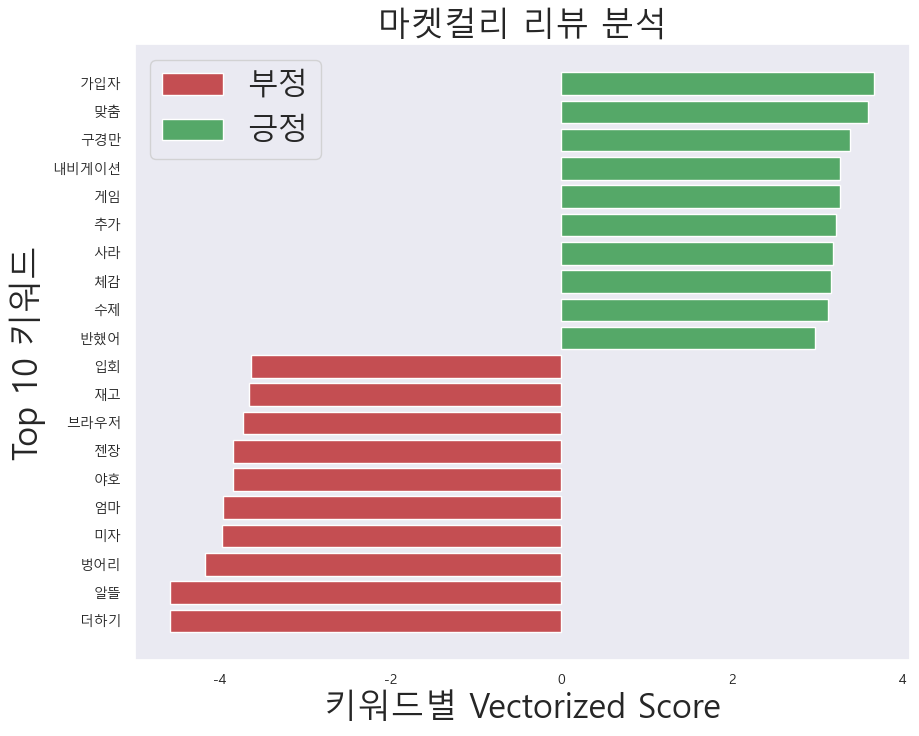

In [35]:
plt.figure(figsize=[10, 8])
plt.barh(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.xlabel('키워드별 Vectorized Score')
plt.ylabel('Top 10 키워드')
plt.title('마켓컬리 리뷰 분석')
plt.show()

## 생각할 것

데이터 전처리
1. morphs가 아니라 nouns로 해야 
2. 불용어 어쩌지...?

데이터 전처리
1. morphs가 아니라 nouns로 해야 
2. 불용어 어쩌지...?
학습 모델
1. train_test_split에 stratify 추가
2. pipeline 파라미터에 smote 추가
3. lgbm? 모델 추가